In [1]:
from sentinelsat import SentinelAPI # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask

import json
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nyc_geo = gpd.read_file('manhattan/POLYGON.shp')

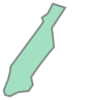

In [3]:
nyc_geo['geometry'].values[0]

In [4]:
m = folium.Map([40.730610, -73.935242], zoom_start=10) # New York City


In [5]:
folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
m

In [6]:
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

In [ ]:
products = api.query(footprint,
                     date = ('20220101', '20220901'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted.shape

In [ ]:
downloaded_image = api.download(products_gdf.index[0])

In [ ]:
downloaded_image['path']

In [ ]:
import zipfile
 
zip_file = downloaded_image['path']

try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
imagery_folders = [x for x in os.listdir() if x.endswith('SAFE')]

In [ ]:
for imagery in imagery_folders:
    l2a_folder = os.listdir(f'{imagery}/GRANULE')[0]
    r10_path = f"{imagery}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
    for band in os.listdir(r10_path):
    # extract bands 2,3, and 4 from r10:

        if 'B02' in band:
            b2 = rio.open(f"{r10_path}/{band}")
        elif 'B03' in band:
            b3 = rio.open(f"{r10_path}/{band}")
        elif 'B04' in band:
            b4 = rio.open(f"{r10_path}/{band}")

In [ ]:

band2_img = b2.read(1)
band3_img = b3.read(1)
band4_img = b4.read(1)

In [30]:
plt.imshow(band4_img[:4000,:4000])

NameError: name 'band4_img' is not defined

In [ ]:
# this will take a while on the Nano..
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [7]:
from rasterio import mask

In [8]:

with rio.open("RGB.tiff") as src:
    out_meta = src.meta.copy()
    nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
    out_image, out_transform = mask.mask(src, [nyc_geo_projected.geometry],crop=False) #TODO: note that projected has to be in the geo from out_meta. 
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


KeyError: 'coordinates'

In [9]:
%debug

> /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/range.py(358)get_loc()
    356                 except ValueError as err:
    357                     raise KeyError(key) from err
--> 358             raise KeyError(key)
    359         return super().get_loc(key, method=method, tolerance=tolerance)
    360 



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(990)_get_value()
    988 
    989         # Similar to Index.get_value, but we do not fall back to positional
--> 990         loc = self.index.get_loc(label)
    991         return self.index._get_values_for_loc(self, loc, label)
    992 



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(882)__getitem__()
    880 
    881         elif key_is_scalar:
--> 882             return self._get_value(key)
    883 
    884         if is_hashable(key):



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(551)_wrapped_pandas_method()
    549     def _wrapped_pandas_method(self, mtd, *args, **kwargs):
    550         """Wrap a generic pandas method to ensure it returns a GeoSeries"""
--> 551         val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)
    552         if type(val) == Series:
    553             val.__class__ = GeoSeries



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(558)__getitem__()
    556 
    557     def __getitem__(self, key):
--> 558         return self._wrapped_pandas_method("__getitem__", key)
    559 
    560     @inherit_doc(pd.Series)



ipdb>  u


> /home/noah/nyc-sentinel/rasterio/_features.pyx(361)rasterio._features._bounds (rasterio/_features.c:7611)()



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/rasterio/features.py(326)bounds()
    322     if 'bbox' in geometry:
    323         return tuple(geometry['bbox'])
    324 
    325     geom = geometry.get('geometry') or geometry
--> 326     return _bounds(geom)



ipdb>  geometry


0    POLYGON ((590232.110 4525934.280, 589419.066 4...
Name: geometry, dtype: geometry


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/rasterio/mask.py(57)<listcomp>()
     55             nodata = 0
     56 
---> 57     all_bounds = [rasterio.features.bounds(shape) for shape in shapes]
     58     minxs, minys, maxxs, maxys = zip(*all_bounds)
     59     mask_bounds = (min(minxs), min(minys), max(maxxs), max(maxys))



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/rasterio/mask.py(57)mask()
     55             nodata = 0
     56 
---> 57     all_bounds = [rasterio.features.bounds(shape) for shape in shapes]
     58     minxs, minys, maxxs, maxys = zip(*all_bounds)
     59     mask_bounds = (min(minxs), min(minys), max(maxxs), max(maxys))



ipdb>  shapes


[0    POLYGON ((590232.110 4525934.280, 589419.066 4...
Name: geometry, dtype: geometry]


ipdb>  rasterio.features.bounds(shape) for shape in shapes


*** SyntaxError: invalid syntax


ipdb>   [rasterio.features.bounds(shape) for shape in shapes]


*** KeyError: 'coordinates'


ipdb>  rasterio.features.bounds


<function bounds at 0x7f53f97ae8>


ipdb>  rasterio.features


<module 'rasterio.features' from '/usr/local/lib/python3.6/dist-packages/rasterio/features.py'>


ipdb>  exit


In [27]:
p1 = nyc_geo_projected['geometry'].values[0]

In [29]:
type(p1)

shapely.geometry.polygon.Polygon

In [11]:
import rasterio

In [23]:
rasterio.features.bounds(nyc_geo_projected.geometry)

KeyError: 'coordinates'

In [25]:
%debug

> /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/range.py(358)get_loc()
    356                 except ValueError as err:
    357                     raise KeyError(key) from err
--> 358             raise KeyError(key)
    359         return super().get_loc(key, method=method, tolerance=tolerance)
    360 



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(990)_get_value()
    988 
    989         # Similar to Index.get_value, but we do not fall back to positional
--> 990         loc = self.index.get_loc(label)
    991         return self.index._get_values_for_loc(self, loc, label)
    992 



ipdb>  self.index


RangeIndex(start=0, stop=1, step=1)


ipdb>  label


'coordinates'


ipdb>  self.index.get_loc('geometry')


*** KeyError: 'geometry'


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(882)__getitem__()
    880 
    881         elif key_is_scalar:
--> 882             return self._get_value(key)
    883 
    884         if is_hashable(key):



ipdb>  yu


*** NameError: name 'yu' is not defined


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(551)_wrapped_pandas_method()
    549     def _wrapped_pandas_method(self, mtd, *args, **kwargs):
    550         """Wrap a generic pandas method to ensure it returns a GeoSeries"""
--> 551         val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)
    552         if type(val) == Series:
    553             val.__class__ = GeoSeries



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(558)__getitem__()
    556 
    557     def __getitem__(self, key):
--> 558         return self._wrapped_pandas_method("__getitem__", key)
    559 
    560     @inherit_doc(pd.Series)



ipdb>  u


> /home/noah/nyc-sentinel/rasterio/_features.pyx(361)rasterio._features._bounds (rasterio/_features.c:7611)()



ipdb>  u


> /usr/local/lib/python3.6/dist-packages/rasterio/features.py(326)bounds()
    322     if 'bbox' in geometry:
    323         return tuple(geometry['bbox'])
    324 
    325     geom = geometry.get('geometry') or geometry
--> 326     return _bounds(geom)



ipdb>  d


> /home/noah/nyc-sentinel/rasterio/_features.pyx(361)rasterio._features._bounds (rasterio/_features.c:7611)()



ipdb>  


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(558)__getitem__()
    556 
    557     def __getitem__(self, key):
--> 558         return self._wrapped_pandas_method("__getitem__", key)
    559 
    560     @inherit_doc(pd.Series)



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(551)_wrapped_pandas_method()
    549     def _wrapped_pandas_method(self, mtd, *args, **kwargs):
    550         """Wrap a generic pandas method to ensure it returns a GeoSeries"""
--> 551         val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)
    552         if type(val) == Series:
    553             val.__class__ = GeoSeries



ipdb>  geom


*** NameError: name 'geom' is not defined


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(558)__getitem__()
    556 
    557     def __getitem__(self, key):
--> 558         return self._wrapped_pandas_method("__getitem__", key)
    559 
    560     @inherit_doc(pd.Series)



ipdb>  u


> /home/noah/nyc-sentinel/rasterio/_features.pyx(361)rasterio._features._bounds (rasterio/_features.c:7611)()



ipdb>  geom


*** NameError: name 'geom' is not defined


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/rasterio/features.py(326)bounds()
    322     if 'bbox' in geometry:
    323         return tuple(geometry['bbox'])
    324 
    325     geom = geometry.get('geometry') or geometry
--> 326     return _bounds(geom)



ipdb>  geom


0    POLYGON ((590232.110 4525934.280, 589419.066 4...
Name: geometry, dtype: geometry


ipdb>  _bounds


<built-in function _bounds>


ipdb>  d


> /home/noah/nyc-sentinel/rasterio/_features.pyx(361)rasterio._features._bounds (rasterio/_features.c:7611)()



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(558)__getitem__()
    556 
    557     def __getitem__(self, key):
--> 558         return self._wrapped_pandas_method("__getitem__", key)
    559 
    560     @inherit_doc(pd.Series)



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py(551)_wrapped_pandas_method()
    549     def _wrapped_pandas_method(self, mtd, *args, **kwargs):
    550         """Wrap a generic pandas method to ensure it returns a GeoSeries"""
--> 551         val = getattr(super(GeoSeries, self), mtd)(*args, **kwargs)
    552         if type(val) == Series:
    553             val.__class__ = GeoSeries



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(882)__getitem__()
    880 
    881         elif key_is_scalar:
--> 882             return self._get_value(key)
    883 
    884         if is_hashable(key):



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(990)_get_value()
    988 
    989         # Similar to Index.get_value, but we do not fall back to positional
--> 990         loc = self.index.get_loc(label)
    991         return self.index._get_values_for_loc(self, loc, label)
    992 



ipdb>  d


> /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/range.py(358)get_loc()
    356                 except ValueError as err:
    357                     raise KeyError(key) from err
--> 358             raise KeyError(key)
    359         return super().get_loc(key, method=method, tolerance=tolerance)
    360 



ipdb>  d


*** Newest frame


ipdb>  u


> /usr/local/lib/python3.6/dist-packages/pandas/core/series.py(990)_get_value()
    988 
    989         # Similar to Index.get_value, but we do not fall back to positional
--> 990         loc = self.index.get_loc(label)
    991         return self.index._get_values_for_loc(self, loc, label)
    992 



ipdb>  self.index


RangeIndex(start=0, stop=1, step=1)


ipdb>  exit


In [ ]:
#geometry is the rater